<a href="https://colab.research.google.com/github/UPstartDeveloper/detecting-fires/blob/master/Detecting_Fires_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Image Classification with Deep Learning 

![Campfire image](https://i.postimg.cc/3x1TLwq2/nathan-lindahl-1j18807-ul0-unsplash.jpg)

Let's see how to do it.

Deep learning has the power to potentially save millions of dollars (and more importantly, lives) in places like California whose annual "fire season" has just arrived.

We're excited you're reading this, and hopefully at the end you'll walk away from this notebook having learned a little more about the **Tensorflow and Keras libraries**, and **how to implement neural networks to solve image classification problems**. 

Let's begin!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)

2.6.0


## Import the Fire Image Dataset

TODO: explain the dataset is at a GitHub repo, so we will need to clone it, and the first step to do that is to connect Google Drive to our Colab environment:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Check to ensure that `gdrive` appears as one of the folders in the current directory:

In [ ]:
! ls

gdrive	sample_data


**TODO**: now we make a directory to hold the files for this project itself (in our Google Drive)

**NOTE**: if any errors w/ running the cell below (e.g. Colab says“[Transport endpoint is not connected](https://stackoverflow.com/questions/49588113/google-colab-script-throws-transport-endpoint-is-not-connected)”) this should be a huge cause for concern. Just remount Google Drive and try again

In [ ]:
%cd gdrive/MyDrive/
%mkdir Detecting-Fires/
%cd Detecting-Fires/

/content/gdrive/MyDrive
/content/gdrive/MyDrive/Detecting-Fires


Now you can go ahead and clone the repo containing the images:

In [ ]:
! git clone https://github.com/UPstartDeveloper/Fire-Detection-Image-Dataset.git

Cloning into 'Fire-Detection-Image-Dataset'...
remote: Enumerating objects: 665, done.
remote: Counting objects: 100% (665/665), done.
remote: Compressing objects: 100% (663/663), done.
remote: Total 665 (delta 4), reused 659 (delta 2), pack-reused 0
Receiving objects: 100% (665/665), 131.49 MiB | 24.16 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (652/652), done.


In [ ]:
!pwd

/content/gdrive/MyDrive/Detecting-Fires


## Explore the data

**TODO**: explain it's good to know the size of the image dataset, as it can impact how you load it into memory, w/o going over Colab's RAM limit

The following cell demonstrates one way to check the number of images we have. 

**NOTE**: The code below shows the paths to the image folders. If you didn't have this information beforehand, there are two ways to get it (and both work equally ok):
1.  more bash commands (e.g. cd, ls, pwd, etc.) OR 
2.  use the folder view on the left side of Colab

In [ ]:
from glob import glob

# use the glob function to show how many images are in each folder
DATA_DIR = 'Fire-Detection-Image-Dataset/Images'
FIRE_IMAGES_PATTERN = f'{DATA_DIR}/Fire_Images/*'
NOT_FIRE_IMAGES_PATTERN = f'{DATA_DIR}/Normal_Images/*'
print(f"No. of fire image samples: {len(glob(FIRE_IMAGES_PATTERN))}")
print(f"No. of non-fire image samples: {len(glob(NOT_FIRE_IMAGES_PATTERN))}")


No. of fire image samples: 110
No. of non-fire image samples: 541


### Structure of the Dataset

As a side note, we can use `os.walk(directory)` to see the alphanumeric order of the image file paths:

In [ ]:
import os

for path in os.walk(DATA_DIR):
  print(path[0])

Fire-Detection-Image-Dataset/Images
Fire-Detection-Image-Dataset/Images/Fire_Images
Fire-Detection-Image-Dataset/Images/Normal_Images


Note the structure of this dataset: it has two folders, each containing the images for their respective class. **This structure makes your life easier when doing image classification**, since in this format Tensorflow 2.x can simply "infer" how many classes are in the dataset, and which images go to which class. This becomes useful loading the dataset in memory (shown later in this tutorial).

### Viewing Images
Using PIL, how can we see what one of the fire images looks like?

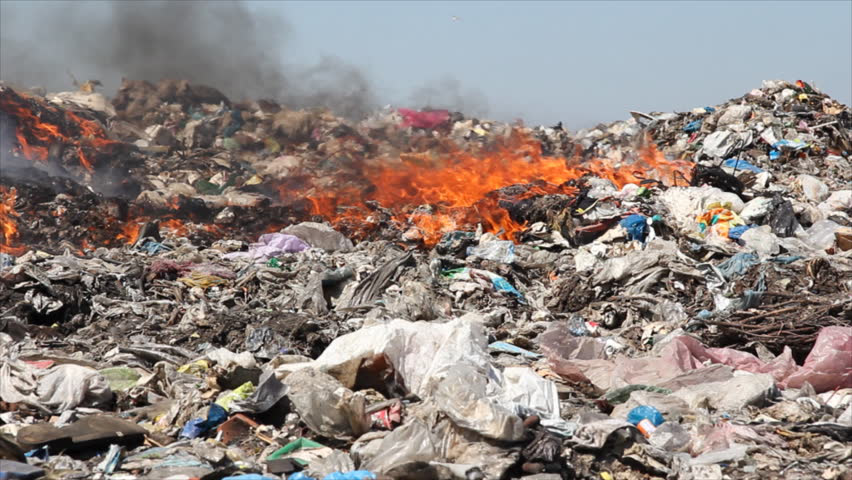

In [ ]:
fire_imgs = list(glob(FIRE_IMAGES_PATTERN))
PIL.Image.open(str(fire_imgs[0]))

As well as what one of the non-fire images looks like:

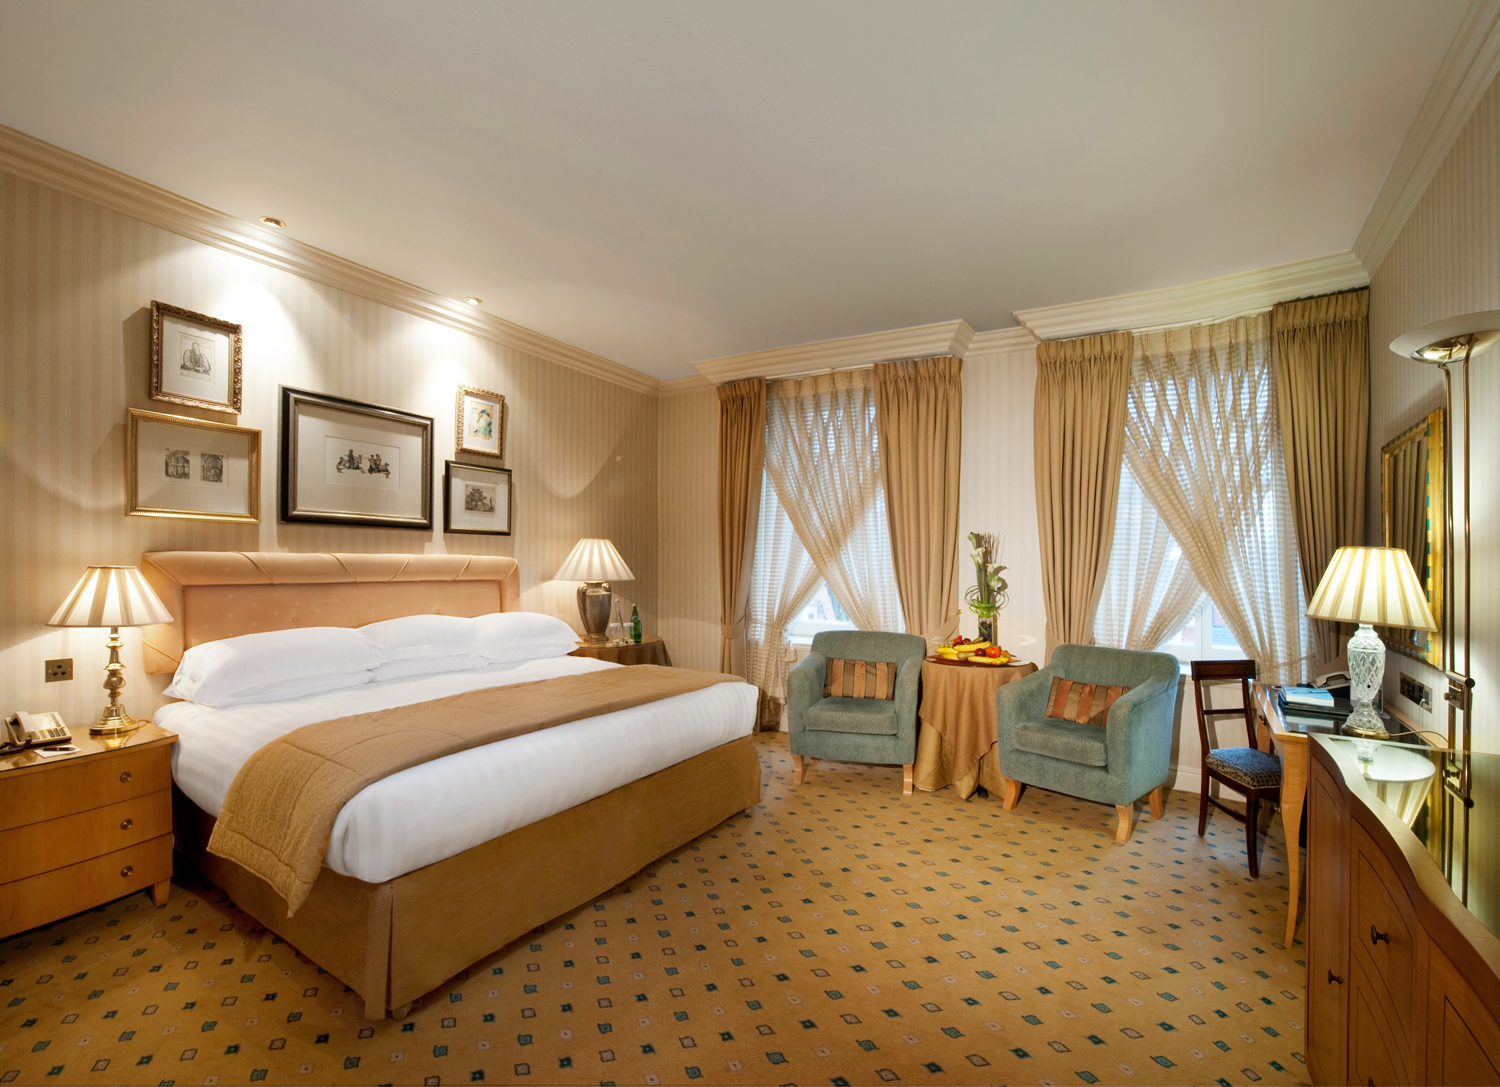

In [ ]:
normal_imgs = list(glob(NOT_FIRE_IMAGES_PATTERN ))
PIL.Image.open(str(normal_imgs[0]))

## Load the dataset

There are a myriad of ways to load datasets (you may also see it referred to as "building input pipelines") in Tensorflow. 

To keep things simple, we'll use the [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function. 

Let's start by defining some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

Use an 80/20 split for the training and validation portions of our dataset:

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 651 files belonging to 2 classes.
Using 521 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 651 files belonging to 2 classes.
Using 130 files for validation.


For good measure, let's verify that Tensorflow correctly read the names of the classes in this dataset:

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Fire_Images', 'Normal_Images']


## Configure the dataset for performance

This is a "nice to have" for smaller datasets. 

**TODO**: give a brief explanation of [`Dataset.prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) and [`Dataset.cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache), or just link to the docs

For exposure, let's see how to use two additional methods on the `tf.data.Dataset` class so our training goes faster:

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Preprocess the data

### Standardizing image dimensions

**TODO**: quickly review the benefits of uniform image sizes? different ways to do it in Tensorflow/Keras?

This `resizing_layer` will be included in the model. It will ensure all the images are 256 x 256 by the time the model trains on them.



In [ ]:
resizing_layer = layers.experimental.preprocessing.Resizing(img_height, img_width)

Note that the reason we are making `resizing_layer` outside the model definition itself is merely for emphasis. 

**TODO**: discuss trade offs of including the layer in the model, in terms of training time, ease of deploymment, etc.?

You will also see people just instantiate it as the first layer in their `model` instantiation (which we will show very shortly!)

### Standardizing pixel values

**TODO**: quickly review the benefits of normalization?

This `normalization_layer` will be included in the model. It will make the pixels in our images to be between 0-1.



In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))

Like the `resizing_layer`, we will also include the `normalization_layer` in the model definition below.

## Build the model

Somewhat arbitrary architecture for our first model starts as a straightforward MLP:

**TODO**: give the spec of the model, and ask students to code it up?

In [ ]:
NUM_CLASSES = 2

model = Sequential([ 
  layers.InputLayer(input_shape=(img_height, img_width, 3)),
  resizing_layer,
  normalization_layer,
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1)
])

### Compile the model

In [ ]:
model.compile(optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy']
)

### Summarize the model

This will be a good thing to come back to when writing reports for your projects!

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               25165952  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 25,174,273
Trainable params: 25,174,273
Non-trainable params: 0
____________________________________________

## Train the model

Remember to store the training results in a variable, so you can visualize the model metrics over time afterwards!

In [ ]:
epochs = 10  # hyperparameter that you may tune

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
17/17 [==============================] - 214s 3s/step - loss: 14.1487 - accuracy: 0.7313 - val_loss: 1.7577 - val_accuracy: 0.8462
Epoch 2/10
17/17 [==============================] - 0s 27ms/step - loss: 2.7649 - accuracy: 0.8004 - val_loss: 2.1848 - val_accuracy: 0.8615
Epoch 3/10
17/17 [==============================] - 0s 24ms/step - loss: 1.4697 - accuracy: 0.7774 - val_loss: 2.5734 - val_accuracy: 0.8462
Epoch 4/10
17/17 [==============================] - 0s 23ms/step - loss: 0.7536 - accuracy: 0.8349 - val_loss: 1.1238 - val_accuracy: 0.8462
Epoch 5/10
17/17 [==============================] - 0s 23ms/step - loss: 0.4877 - accuracy: 0.8829 - val_loss: 0.7020 - val_accuracy: 0.7077
Epoch 6/10
17/17 [==============================] - 0s 23ms/step - loss: 0.2945 - accuracy: 0.8810 - val_loss: 0.4500 - val_accuracy: 0.8154
Epoch 7/10
17/17 [==============================] - 0s 23ms/step - loss: 0.2111 - accuracy: 0.9117 - val_loss: 0.4399 - val_accuracy: 0.8846
Epoch 8/10
1

## Evaluate the model

### Visualize the training results

In [ ]:
def plot_training_results(history):
    """Visualize results of the model training using Matplotlib.

    The visualization will include charts for accuracy and loss, 
    on the training and as well as validation data sets.

    Parameters:
      history(tf.keras.callbacks.History): contains data on how the 
                                           model metrics changed over the 
                                           course of training
    
    Returns: None

    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


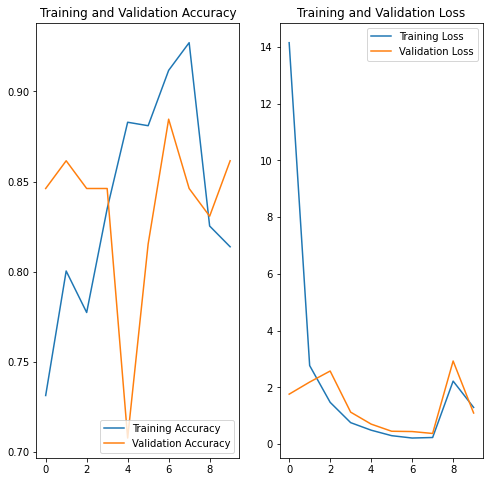

In [ ]:
plot_training_results(history)

**TODO**: make some comments on the visualization, how it make inform hyperparameter optimization, model architecture, use of callbacks, etc.

## Common Approaches to Reduce Overfitting

### Data augmentation

A couple of new layers we will add to the model in a moment, to add more variation in the dataset:

In [ ]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(
        "horizontal", input_shape=(img_height, img_width,3)
    ),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

Take a look at some example effects of data augmentation to the images:

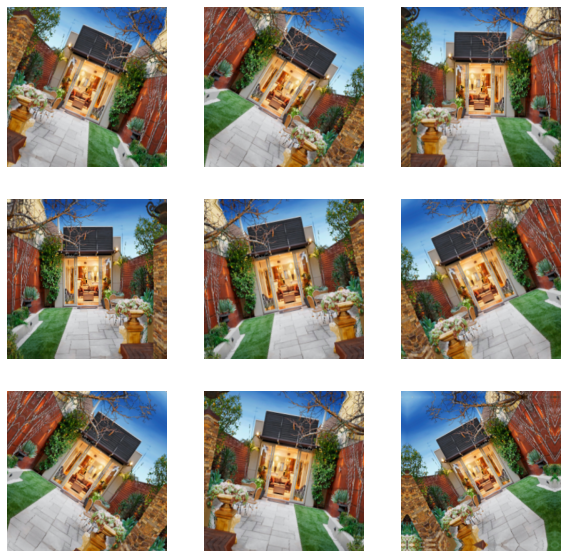

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)  # editing the images
    ax = plt.subplot(3, 3, i + 1)  # adding a new row to our Matplotlib chart
    plt.imshow(augmented_images[0].numpy().astype("uint8"))  # showing the image
    plt.axis("off")

### Regularization via Dropout layers

**TODO: discuss what dropout is?**

Let's redefine the model now, with new layers for data augmentation and dropout:

In [ ]:
model = Sequential([ 
  layers.InputLayer(input_shape=(img_height, img_width, 3)),
  data_augmentation,
  resizing_layer,
  normalization_layer,
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),  # the 
  layers.Dense(64, activation='relu'),
  layers.Dense(1)
])

## Recompile and Retrain

In [ ]:
model.compile(optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy']
)

### Discussion Question

BEFORE you re-sumarize the model: do you think the have the parameters of the will have changed? Why/why not?

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
resizing (Resizing)          (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               25165952  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [ ]:
epochs = 10  # hyperparameter that you may tune

history_updated_model = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
17/17 [==============================] - 1s 38ms/step - loss: 0.3727 - accuracy: 0.8676 - val_loss: 0.5000 - val_accuracy: 0.8308
Epoch 2/10
17/17 [==============================] - 1s 32ms/step - loss: 0.4046 - accuracy: 0.8349 - val_loss: 0.4362 - val_accuracy: 0.7538
Epoch 3/10
17/17 [==============================] - 1s 32ms/step - loss: 0.3505 - accuracy: 0.8330 - val_loss: 0.4001 - val_accuracy: 0.8308
Epoch 4/10
17/17 [==============================] - 1s 32ms/step - loss: 0.3810 - accuracy: 0.8503 - val_loss: 0.3228 - val_accuracy: 0.8615
Epoch 5/10
17/17 [==============================] - 1s 31ms/step - loss: 0.4160 - accuracy: 0.8292 - val_loss: 0.4146 - val_accuracy: 0.8077
Epoch 6/10
17/17 [==============================] - 1s 31ms/step - loss: 0.3925 - accuracy: 0.8004 - val_loss: 0.5015 - val_accuracy: 0.6077
Epoch 7/10
17/17 [==============================] - 1s 31ms/step - loss: 0.4271 - accuracy: 0.8311 - val_loss: 0.4986 - val_accuracy: 0.8308
Epoch 8/10
17

### Visualize the New Results

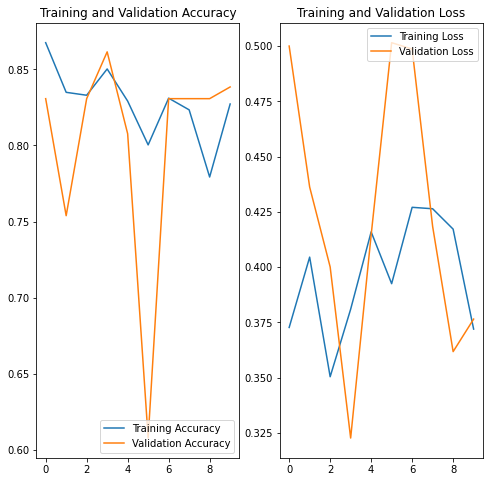

In [ ]:
plot_training_results(history_updated_model)

## Predict on New Data

In [ ]:
def predict_new_image(image_url, standard_height, 
                      standard_width, model):
    """Classify a new image (previously not in the dataset at all).
    
       Parameters: 
       image_url(str): an address where we can get the image from
                      (can be stored locally or somewhere on the Web via HTTP)
       standard_height(int): the height that the image needs to be for the model
       standard_width(int): the width that the image needs to be for the model
       model(Model): the neural network making the prediction
                               
       Returns: None
       
    """
    # A: load the image in memory
    img_path = tf.keras.utils.get_file(origin=image_url)
    img = keras.preprocessing.image.load_img(
        img_path, 
        target_size=(standard_height, standard_width)
    )
    # B: make a mini-dataset w/ the image
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    # C: classify the image using the model
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    # D: report the prediction
    label = class_names[np.argmax(score)]
    percent = 100 * np.max(score)
    print(
        f"This image most likely belongs to {label} with a "\
        f"{percent}% confidence."
    )


### Prediction on a Fire Image

In [ ]:
fire_url = 'https://images.unsplash.com/photo-1497906539264-eb74442e37a9?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=668&q=80'
predict_new_image(fire_url, img_height, img_width, model)

This image most likely belongs to Fire_Images with a 100.0% confidence.


### Prediction on a Normal Image

In [ ]:
flower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
predict_new_image(flower_url, img_height, img_width, model)

131072/117948 [=================================] - 0s 0us/step
This image most likely belongs to Fire_Images with a 100.0% confidence.


**TODO**: include how to make a confusion matrix? use model.evaluate?

## Export for production

**TODO**: do we want do include this?

In [ ]:
def save_model(model, weights_file, architecture_file):
    """Save the model weights and architecture.
    
       Parameters: 
       model(Model): keras Model object being saved
       weights_file(str): name of the Hadoop file where
                          weights will be saved
       architecture_file(str): name of the JSON file where 
                               model architecture is to be
                               saved
                               
       Returns: None
       
    """
    # Save the weights
    model.save_weights(f'{weights_file}.h5')
    # Save the architecture
    with open(f'{architecture_file}.json', 'w') as f:
        f.write(model.to_json())
    return None

## Write a Project Summary and Conclusion

**TODO**: do we want do include this?

## Credits and Resources

This tutorial was inspired by the ["Image classification"](https://www.tensorflow.org/tutorials/images/classification) tutorial on the official Tensorflow documentation. You might consider reading that tutorial after this one, to continue feeding your curiosity!